In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout, MaxPooling2D, Flatten, BatchNormalization, Activation, ReLU, Input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc
from learningratefinder import LearningRateFinder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random

from random import seed, shuffle
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral)
import cv2

tf.__version__

'2.2.0'

In [0]:
#Donwload the datasets
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-14 17:59:22--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.11, 130.117.252.16, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy’

train-images.npy    100%[===================>] 127.34M  27.8MB/s    in 8.3s    

2020-05-14 17:59:31 (15.4 MB/s) - ‘train-images.npy’ saved [133527680/133527680]

--2020-05-14 17:59:35--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.13, 130.117.252.10, 130.117.252.16, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.25

In [0]:
def get_encoded_labels(class_count_dict):
  le = LabelEncoder()
  encoded_labels = le.fit_transform(list(class_count_dict.keys()))
  return encoded_labels

def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Train vs Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train vs Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [0]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"
test_images_path = "test-images.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

test_images = np.load(test_images_path)

# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]


In [0]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [0]:
sharp_resized_array = []
for i in range(len(train_images)):
  img = train_images[i]
  resized = cv2.resize(img, (100, 100))
  sharp = unsharp_mask(resized)
  sharp_resized_array.append(np.array(sharp))

In [0]:
sharp_resized_np = np.array(sharp_resized_array)
sharp_resized_np = sharp_resized_np.astype('float32')
sharp_resized_np = preprocess_input(sharp_resized_np)

In [0]:
train_labels_cat = to_categorical(train_labels, 38)

In [0]:
#Creating Validation Dataset
x_train, x_val, y_train, y_val = train_test_split(sharp_resized_np, train_labels_cat, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(34772, 100, 100, 3) (34772, 38) (8694, 100, 100, 3) (8694, 38)
(31294, 100, 100, 3) (31294, 38) (3478, 100, 100, 3) (3478, 38)


## EfficientNet

In [0]:
!pip install efficientnet

In [0]:
from efficientnet.tfkeras import EfficientNetB3, EfficientNetB7

In [0]:
base_model = EfficientNetB7(weights = 'imagenet', include_top = False,
                       input_tensor = Input(shape = (100, 100, 3)))

258441216/258434480 [==============================] - 3s 0us/step


In [0]:
base_model.summary()

In [0]:
set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block7d_expand_conv':
    set_trainable = True
  if(set_trainable):
    layer.trainable = True
  else:
    layer.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
preds = Dense(38, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
                  activity_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs = base_model.inputs, outputs = preds)

In [0]:
checkpoints_path = 'EffNet.h5'
mc = ModelCheckpoint(filepath = checkpoints_path, monitor='val_loss', verbose=1, 
                     save_best_only=True, save_weights_only=False, mode='min', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=7, min_lr=1e-5, verbose = 1)

opt = Adam(lr = 1e-3, decay=1e-3/50)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")


((31294, 100, 100, 3),
 (31294, 38),
 (8694, 100, 100, 3),
 (8694, 38),
 (3478, 100, 100, 3),
 (3478, 38))

In [0]:
lrf = LearningRateFinder(model)
lrf.find(trainData=aug.flow(x_train, y_train, batch_size=128),
startLR=1e-10, endLR=1e+1,
stepsPerEpoch=np.ceil((len(x_train) / 128)),
batchSize=128)

Epoch 1/9
245/245 [==============================] - 83s 339ms/step - loss: 4.4737 - accuracy: 0.0213
Epoch 2/9
245/245 [==============================] - 83s 338ms/step - loss: 4.4727 - accuracy: 0.0213
Epoch 3/9
245/245 [==============================] - 83s 337ms/step - loss: 4.4698 - accuracy: 0.0219
Epoch 4/9
245/245 [==============================] - 83s 338ms/step - loss: 4.4318 - accuracy: 0.0303
Epoch 5/9
245/245 [==============================] - 83s 339ms/step - loss: 3.9535 - accuracy: 0.2034
Epoch 6/9
245/245 [==============================] - 84s 341ms/step - loss: 2.3241 - accuracy: 0.5105
Epoch 7/9
245/245 [==============================] - 83s 341ms/step - loss: 2.1375 - accuracy: 0.5546
Epoch 8/9
245/245 [==============================] - 82s 336ms/step - loss: 11.8683 - accuracy: 0.3016


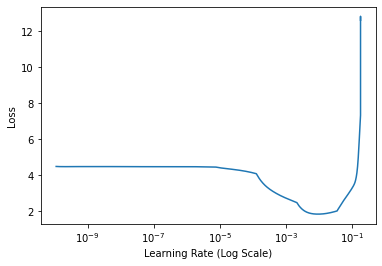

In [0]:
lrf.plot_loss()

In [0]:
base_model = EfficientNetB7(weights = 'imagenet', include_top = False,
                       input_tensor = Input(shape = (100, 100, 3)))

In [0]:
set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block7d_expand_conv':
    set_trainable = True
  if(set_trainable):
    layer.trainable = True
  else:
    layer.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
preds = Dense(38, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
                  activity_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs = base_model.inputs, outputs = preds)

In [0]:
checkpoints_path = 'EffNet.h5'
mc = ModelCheckpoint(filepath = checkpoints_path, monitor='val_loss', verbose=1, 
                     save_best_only=True, save_weights_only=False, mode='min', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=7, min_lr=1e-5, verbose = 1)

opt = Adam(lr = 1e-3, decay=1e-3/50)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit_generator(aug.flow(x_train, y_train,batch_size=128),
          epochs=50,
          verbose=1,
          steps_per_epoch = np.ceil((len(x_train)/ float(128))),
          validation_data=(x_val, y_val), callbacks = [mc, reduce_lr])

Epoch 1/50
245/245 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.5498
Epoch 00001: val_loss improved from inf to 1.21744, saving model to EffNet.h5
245/245 [==============================] - 112s 457ms/step - loss: 1.9954 - accuracy: 0.5498 - val_loss: 1.2174 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 2/50
245/245 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.6870
Epoch 00002: val_loss improved from 1.21744 to 0.95509, saving model to EffNet.h5
245/245 [==============================] - 106s 434ms/step - loss: 1.2943 - accuracy: 0.6870 - val_loss: 0.9551 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 3/50
245/245 [==============================] - ETA: 0s - loss: 1.1724 - accuracy: 0.7156
Epoch 00003: val_loss improved from 0.95509 to 0.92725, saving model to EffNet.h5
245/245 [==============================] - 107s 435ms/step - loss: 1.1724 - accuracy: 0.7156 - val_loss: 0.9272 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 4/50
245/245 [======

In [0]:
#LOAD THE EFFNET MODEL HERE AND FINE TUNE IT

In [0]:
for layer in base_model.layers:
  layer.trainable = True

opt = Adam(lr = 1e-5, decay=1e-5/50)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit_generator(aug.flow(x_train, y_train,batch_size=128),
          epochs=30,
          verbose=1,
          steps_per_epoch = np.ceil((len(x_train)/ float(128))),
          validation_data=(x_val, y_val), callbacks = [mc, reduce_lr])

Epoch 1/30


ResourceExhaustedError: ignored

In [0]:
def plot_LR(model, batch_size, x_train, y_train, aug, class_weight=None):
  lrf = LearningRateFinder(model)
  lrf.find(aug.flow(x_train, y_train, batch_size=batch_size),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(x_train) / batch_size)),
    batchSize=batch_size)
 
  lrf.plot_loss()

In [0]:
#defining the model
def get_model(shape=(224, 224, 3), weights = None):
    base_model = DenseNet121(include_top = False, weights = weights, 
                             input_tensor=Input(shape=shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    #x = Dense(512, activation = 'relu')(x)
    preds = Dense(38, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
                  activity_regularizer=regularizers.l2(0.01))(x)

    model = Model(inputs = base_model.inputs, outputs = preds)

    return model

In [0]:
from collections import Counter

data_counter = Counter(train_labels)
unique_class_indices = data_counter.keys()
class_count_dict = {}

for _class_index in unique_class_indices:
    print("Class Index : ", _class_index)
    print("Class Name : ", class_names[_class_index])
    print("Number of images in the dataset : ", data_counter[_class_index])
    class_count_dict[_class_index] = data_counter[_class_index]
    print("="*100)

Class Index :  7
Class Name :  corn-maize-cercospora-leaf-spot-gray-leaf-spot
Number of images in the dataset :  410
Class Index :  4
Class Name :  blueberry-healthy
Number of images in the dataset :  1205
Class Index :  9
Class Name :  corn-maize-healthy
Number of images in the dataset :  925
Class Index :  29
Class Name :  tomato-early-blight
Number of images in the dataset :  806
Class Index :  20
Class Name :  potato-early-blight
Number of images in the dataset :  808
Class Index :  15
Class Name :  orange-haunglongbing-citrus-greening
Number of images in the dataset :  4422
Class Index :  37
Class Name :  tomato-tomato-yellow-leaf-curl-virus
Number of images in the dataset :  4238
Class Index :  5
Class Name :  cherry-including-sour-healthy
Number of images in the dataset :  666
Class Index :  28
Class Name :  tomato-bacterial-spot
Number of images in the dataset :  1738
Class Index :  16
Class Name :  peach-bacterial-spot
Number of images in the dataset :  1864
Class Index :  14


In [0]:
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = list(labels_dict.keys())
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

class_w = create_class_weight(class_count_dict)


In [0]:
l = sorted(class_count_dict.values())
for k in l:
  for key, val in class_count_dict.items():
    if(val == k):
      #print(key, class_count_dict[key])
      sorted_dict[key] = class_count_dict[key]

encoded_labels = get_encoded_labels(class_count_dict)

In [0]:
sorted_dict = sorted(class_count_dict.items(), key=lambda x: x[1])


In [0]:
sorted_dict

[(21, 120),
 (2, 222),
 (17, 286),
 (23, 297),
 (36, 301),
 (13, 337),
 (26, 376),
 (7, 410),
 (1, 506),
 (0, 511),
 (5, 666),
 (32, 763),
 (22, 789),
 (10, 794),
 (18, 799),
 (29, 806),
 (20, 808),
 (6, 820),
 (14, 865),
 (27, 883),
 (9, 925),
 (11, 953),
 (8, 960),
 (12, 1090),
 (35, 1117),
 (19, 1165),
 (4, 1205),
 (30, 1266),
 (3, 1313),
 (34, 1327),
 (33, 1439),
 (25, 1476),
 (31, 1522),
 (28, 1738),
 (16, 1864),
 (24, 4087),
 (37, 4238),
 (15, 4422)]

In [0]:
minority_classes = []
for key in class_count_dict.keys():
  if(class_count_dict[key] < 900):
    minority_classes.append(key)
(minority_classes)

[7, 29, 20, 5, 14, 10, 18, 23, 32, 22, 17, 6, 13, 27, 0, 1, 21, 36, 26, 2]

# Augmenting the Minority Class#

In [0]:
# Minority List -> minority_classes
# Iterate through 'minority_classes', pick that image from the train data where the label is from the minority class
new_data=[]
new_labels = []
count = 0
for i in train_labels:
  if(i in minority_classes):
    count+=1
    img = train_images[i]
    img_PIL = Image.fromarray(img)
    img_PIL = img_PIL.convert("RGB")
    r,g,b = img_PIL.split()
    r = r.convert("RGB")
    g = g.convert("RGB")
    b = b.convert("RGB")
    new_data.append(np.array(r))
    new_data.append(np.array(g))
    new_data.append(np.array(b))
    new_labels.append(i)
    new_labels.append(i)
    new_labels.append(i)
    

In [0]:
np.array(new_data).shape, np.array(new_labels).shape

((34077, 32, 32, 3), (34077,))

In [0]:
NEW_TRAIN_IMAGES = np.append(train_images, np.array(new_data), axis = 0)
NEW_TRAIN_LABELS = np.append(train_labels, np.array(new_labels), axis = 0)
NEW_TRAIN_IMAGES.shape, NEW_TRAIN_LABELS.shape

((77543, 32, 32, 3), (77543,))

In [0]:
FINAL_LABELS = to_categorical(NEW_TRAIN_LABELS, 38)
FINAL_LABELS.shape

(77543, 38)

In [0]:
FINAL_DATA = []
for i in range(len(NEW_TRAIN_IMAGES)):
  img = NEW_TRAIN_IMAGES[i]
  resized = cv2.resize(img, (128, 128))
  sharp = unsharp_mask(resized)
  FINAL_DATA.append(np.array(sharp))

np.array(FINAL_DATA).shape

(77543, 128, 128, 3)

In [0]:
#Creating Validation Dataset
x_train, x_test, y_train, y_test = train_test_split(np.array(FINAL_DATA), FINAL_LABELS, test_size = 0.1, random_state = 42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(69788, 128, 128, 3) (69788, 38) (7755, 128, 128, 3) (7755, 38)
(55830, 128, 128, 3) (55830, 38) (13958, 128, 128, 3) (13958, 38)


In [0]:
x_train.astype('float32')
x_val.astype('float32')
x_test.astype('float32')

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test = preprocess_input(x_test)

## Basic Preprocessing

In [0]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((55830, 128, 128, 3),
 (55830, 38),
 (13958, 128, 128, 3),
 (13958, 38),
 (7755, 128, 128, 3),
 (7755, 38))

In [0]:
test_model = get_model(shape = (128, 128, 3), weights='imagenet')
for layer in test_model.layers[:20]:
  layer.trainable = False

opt = SGD()
test_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lrf = LearningRateFinder(test_model)
lrf.find(trainData=aug.flow(x_train, y_train, batch_size=128),
startLR=1e-10, endLR=1e+1,
stepsPerEpoch=np.ceil((len(x_train) / 128)),
batchSize=128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
437/437 [==============================] - 361s 826ms/step - loss: 5.6484 - accuracy: 0.0215
Epoch 2/5
437/437 [==============================] - 358s 820ms/step - loss: 5.6376 - accuracy: 0.0210
Epoch 3/5
437/437 [==============================] - 358s 820ms/step - loss: 5.3961 - accuracy: 0.0325
Epoch 4/5
437/437 [==============================] - 358s 820ms/step - loss: 2.2274 - accuracy: 0.6279
Epoch 5/5
437/437 [==============================] - 357s 816ms/step - loss: 2.9510 - accuracy: 0.4486


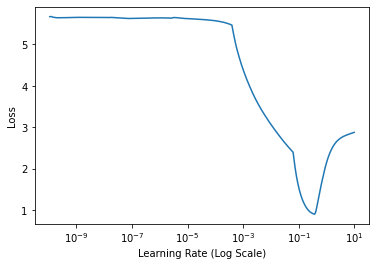

In [0]:
lrf.plot_loss()


## Defining the model with the optimum LR

In [0]:
model = get_model(shape=(128,128,3), weights='imagenet')

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
checkpoints_path = 'Densenet-BALANCED_DATA.h5'
mc = ModelCheckpoint(filepath = checkpoints_path, monitor='val_loss', verbose=1, 
                     save_best_only=True, save_weights_only=False, mode='min', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-3, verbose = 1)

opt = SGD(lr = 9e-2, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=70,
          verbose=1,
          validation_data=(x_val, y_val), callbacks = [mc, reduce_lr])

Epoch 1/70
437/437 [==============================] - ETA: 0s - loss: 1.8747 - accuracy: 0.6621
Epoch 00001: val_loss improved from inf to 2.05249, saving model to Densenet-BALANCED_DATA.h5
437/437 [==============================] - 114s 262ms/step - loss: 1.8747 - accuracy: 0.6621 - val_loss: 2.0525 - val_accuracy: 0.5088 - lr: 0.0900
Epoch 2/70
437/437 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.8394
Epoch 00002: val_loss improved from 2.05249 to 0.90978, saving model to Densenet-BALANCED_DATA.h5
437/437 [==============================] - 112s 257ms/step - loss: 0.7893 - accuracy: 0.8394 - val_loss: 0.9098 - val_accuracy: 0.7952 - lr: 0.0900
Epoch 3/70
437/437 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.8706
Epoch 00003: val_loss improved from 0.90978 to 0.70894, saving model to Densenet-BALANCED_DATA.h5
437/437 [==============================] - 112s 256ms/step - loss: 0.6415 - accuracy: 0.8706 - val_loss: 0.7089 - val_accuracy

In [0]:
best_model = load_model('Densenet-BALANCED_DATA.h5')

In [0]:
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06869985163211823
Test accuracy: 0.9904577732086182


In [0]:
#Preprocess Test Images
sharp_resized_array_TEST = []
for i in range(len(test_images)):
  img = test_images[i]
  resized = cv2.resize(img, (128, 128))
  sharp = unsharp_mask(resized)
  sharp_resized_array_TEST.append(np.array(sharp))

In [0]:
sharp_resized_array_TEST_np = np.array(sharp_resized_array_TEST)
sharp_resized_array_TEST_np.astype('float32')
sharp_resized_array_TEST_np = preprocess_input(sharp_resized_array_TEST_np)

(10838, 32, 32, 3)

In [0]:
pred_class = []
for i in range(len(sharp_resized_array_TEST_np)):
  img = sharp_resized_array_TEST_np[i]
  img = np.expand_dims(img, axis = 0)
  prediction = best_model.predict(img)
  pred_class.append(np.argmax(prediction))

In [0]:
pred_class

In [0]:
submission = pd.DataFrame(pred_class)
submission.to_csv('Densenet-BALANCED_DATA.csv', header=['class_index'],index=False)

In [0]:
submission.head()

,0
0,37
1,30
2,34
3,30
4,6


#TESTING